# 1. Loading the data

In [16]:
import pandas as pd

def traces(i):
    '''Get detrended traces of dataset @i'''
    return pd.read_csv('data/WBI%s.csv' % i, index_col=0)

def derivs(i):
    '''Get deivatives of dataset @i'''
    return pd.read_csv('data/dWBI%s.csv' % i, index_col=0)

# Some code for later
from sklearn.preprocessing import MinMaxScaler 
minmax = MinMaxScaler()
from sklearn.preprocessing import StandardScaler
meanstd = StandardScaler()

# 2. Data Visualization

## Traces on single dataset

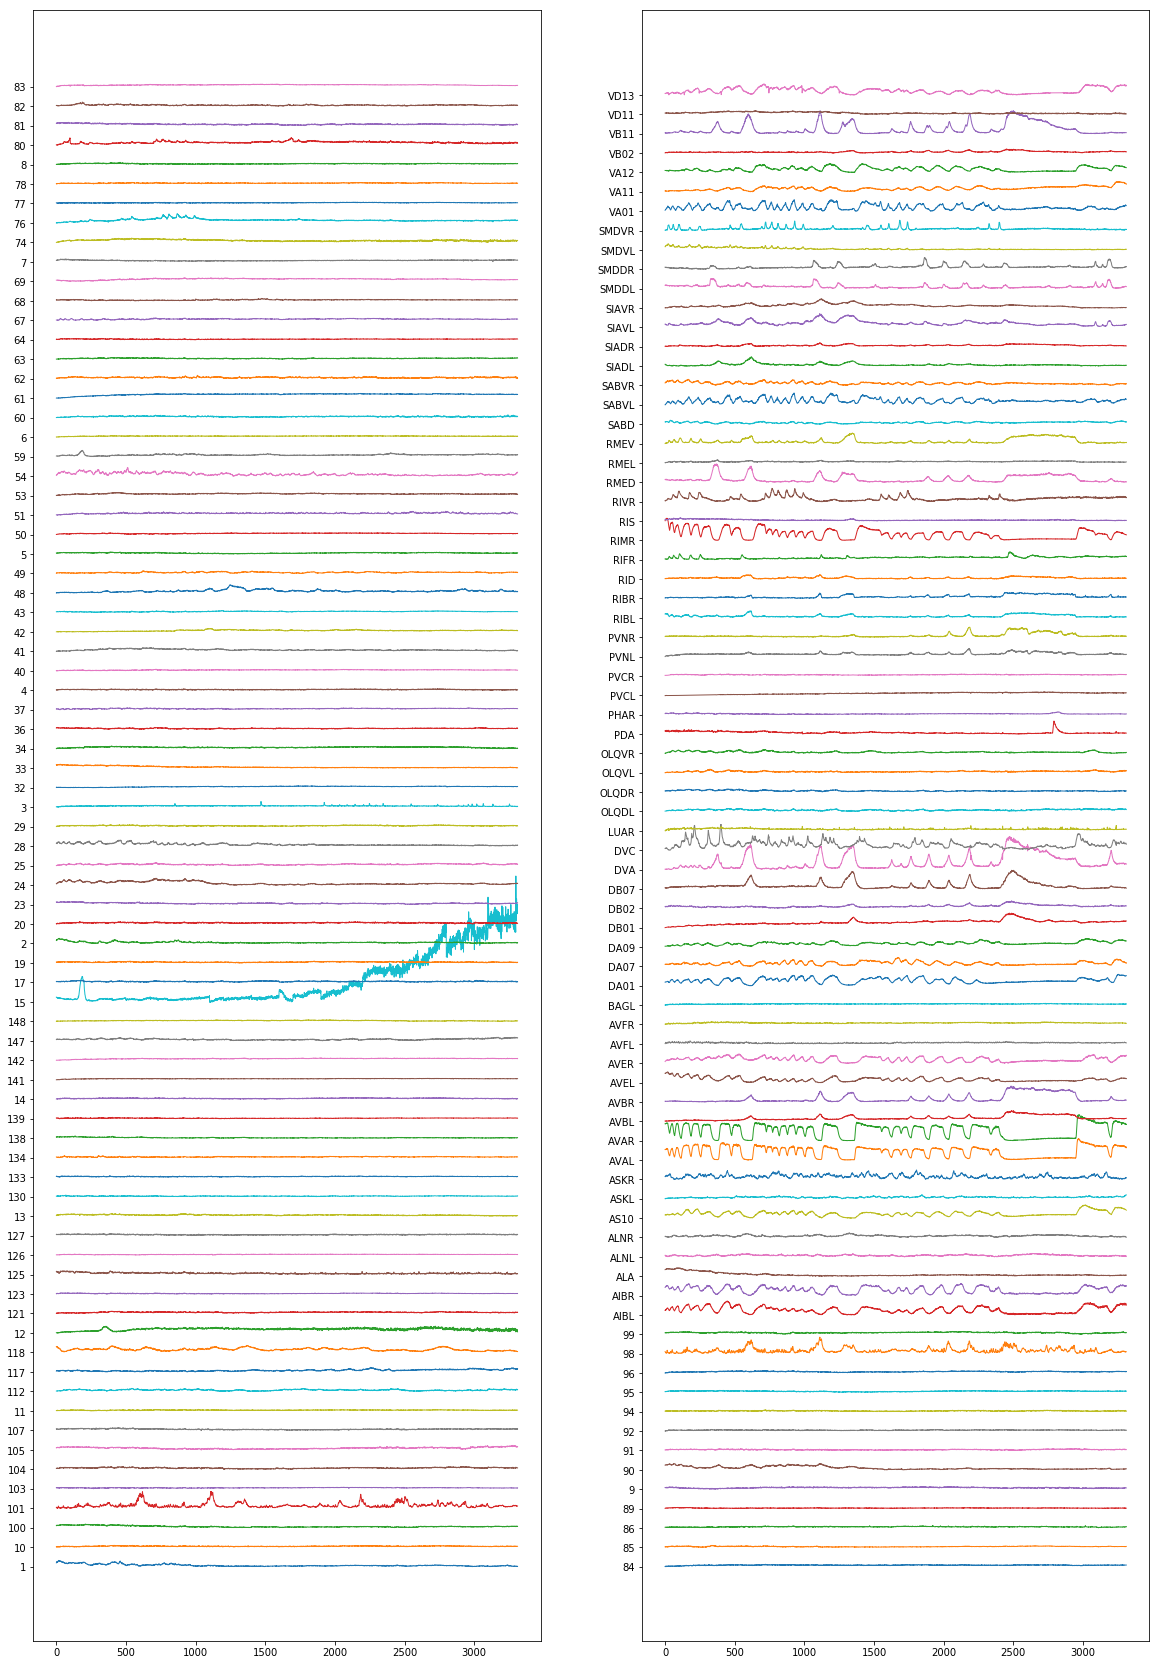

In [3]:
import pylab as plt
import numpy as np

def plot_all_traces(df, scaler=None):
    '''Plot all traces of dataset @df'''
    plt.figure(figsize=(20,30))
    if scaler is not None:
        df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
    traces = df.values.copy()
    stretch = 2
    N = traces.shape[1]//2
    for i in range(traces.shape[1]):
        traces[:,i] += stretch * (i - N * (i > N-1))
    t1 = traces[:,:N]
    t2 = traces[:,N:]
    plt.subplot(121)
    plt.plot(t1, linewidth=1)
    plt.yticks(np.arange(0,N*stretch,stretch),labels=df.columns[:N])
    plt.subplot(122)
    plt.plot(t2, linewidth=1)
    plt.yticks(np.arange(0,N*stretch,stretch),labels=df.columns[N:])
    plt.show()
    plt.close()
    
    
# Call the function for 1 dataset 
t0 = traces(0)
plot_all_traces(t0)

## Heatmap on single dataset

Run the code below and look at the result.
The heatmap is obviously pretty unreadable, why ?

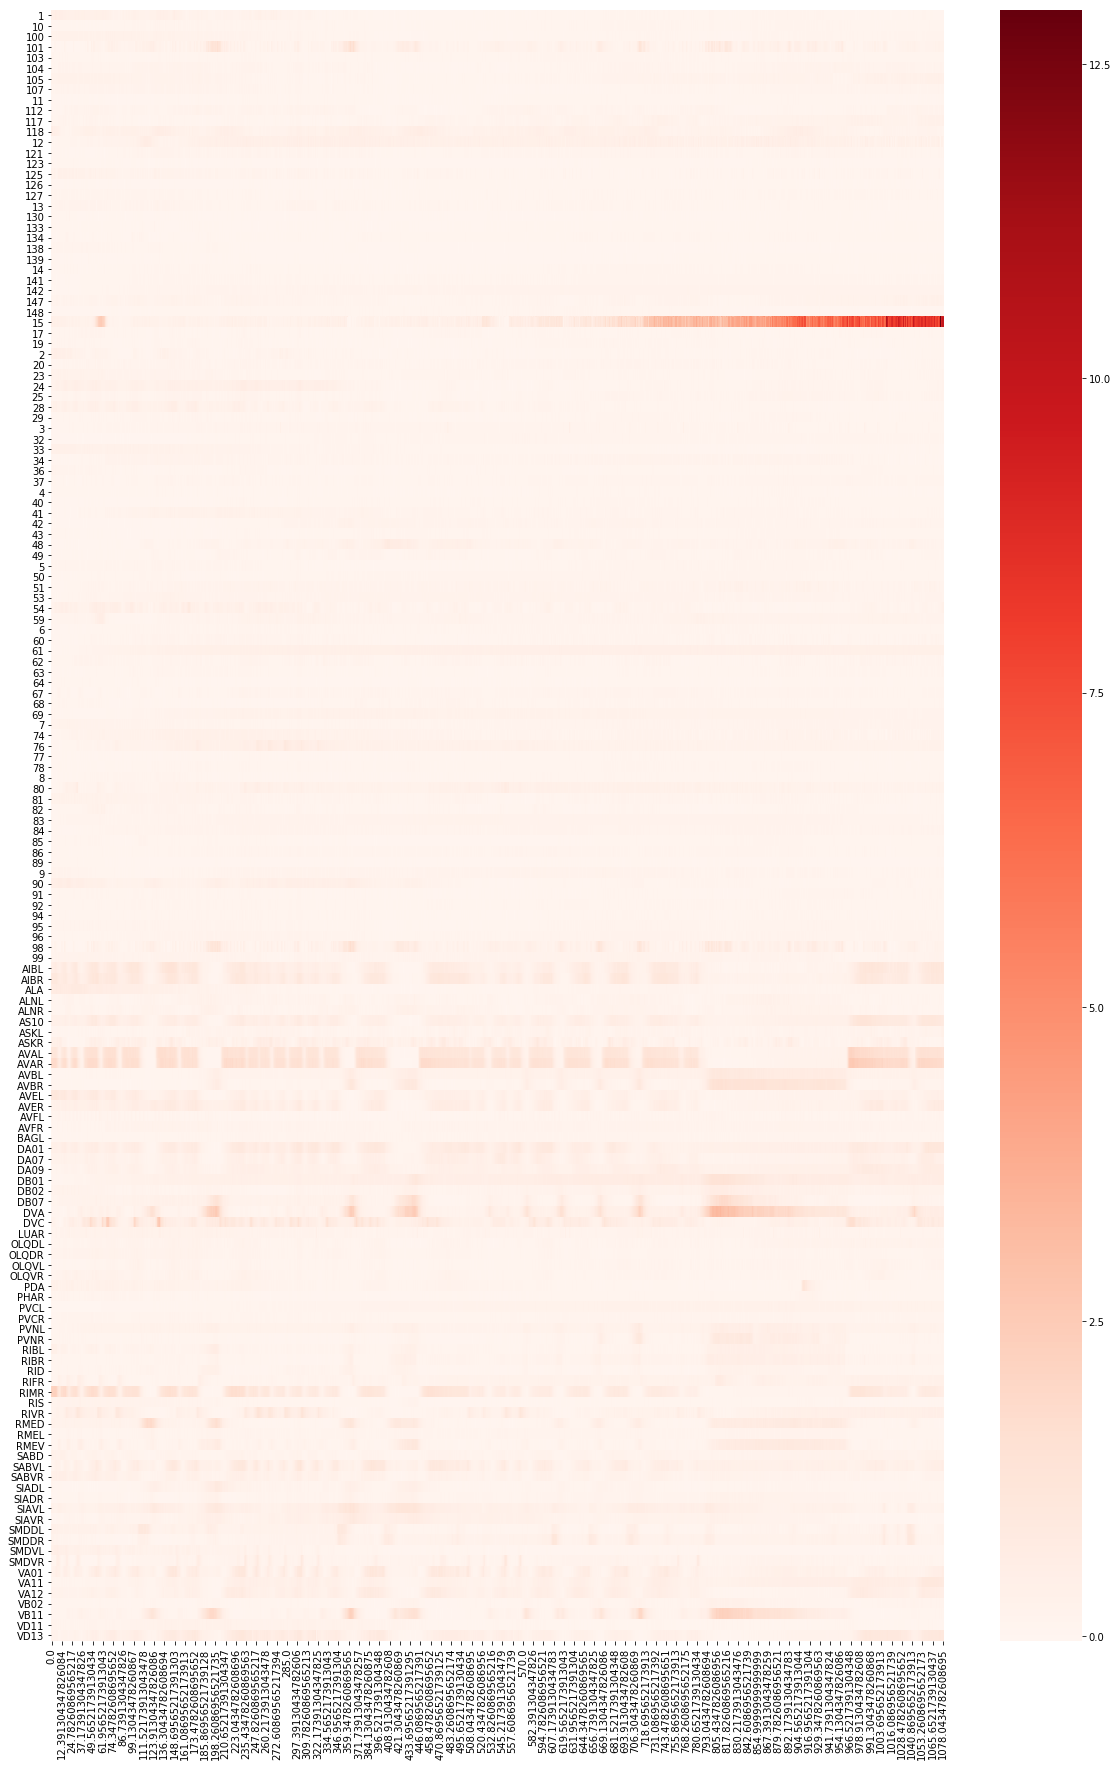

In [4]:
import seaborn as sns

cmaps = ['jet', 'Reds', 'flag']

def heatmap(df, scaler=None, cmap='flag'):
    plt.figure(figsize=(20,30))
    if scaler is not None:
        df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
    sns.heatmap(df.T, cmap=cmap)
#     plt.plot(t2, linewidth=1)
#     plt.yticks(np.arange(0,N*stretch,stretch),labels=df.columns[N:])
    plt.show()
    plt.close()
    
heatmap(t0, cmap='flag')

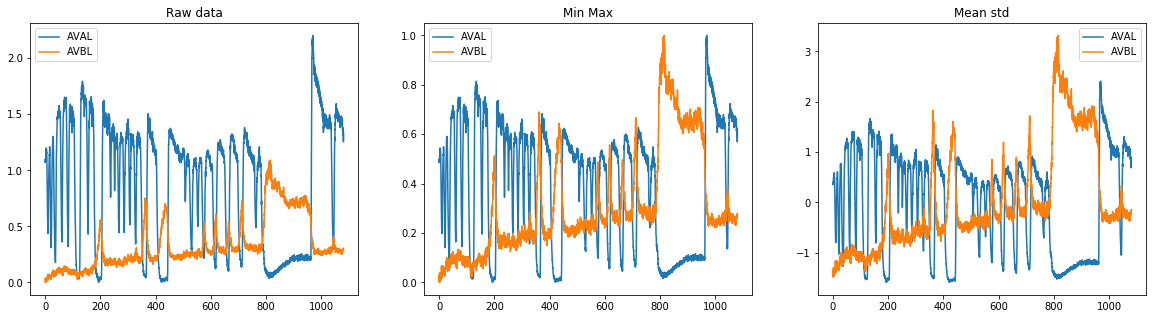

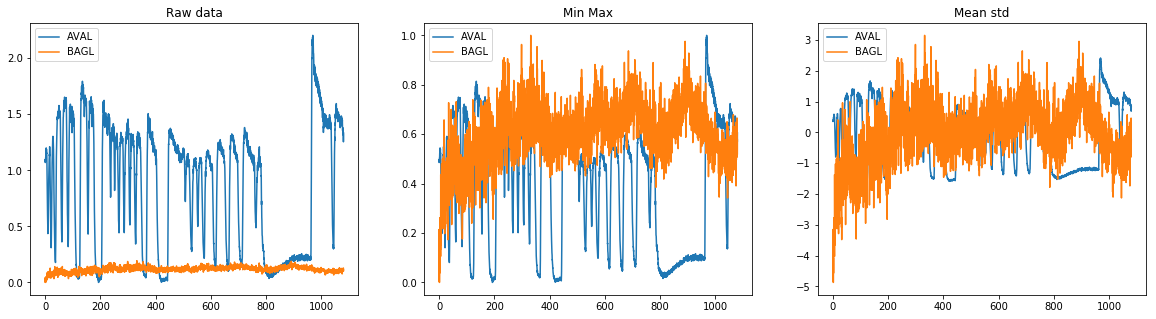

In [38]:
def compare_norm(neurons=NS):
    """Compare the influence of different normalization methods on @neurons"""
    def plot_avab(df=t0, scaler=None):
        if scaler is not None:
            df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
        for n in neurons:
            plt.plot(df[n], label=n)
        plt.legend()
        
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Raw data')
    plot_avab()
    plt.subplot(132)
    plt.title('Min Max')
    plot_avab(scaler=minmax)
    plt.subplot(133)
    plt.title('Mean std')
    plot_avab(scaler=meanstd)
    plt.show()
    
compare_norm(['AVAL', 'AVBL'])
compare_norm(['AVAL', 'BAGL'])

In [36]:
N_sets = 6

all_names = set()
for i in range(N_sets):
    all_names = all_names.union(set(traces(i).columns))
labelled = [n  for n in all_names if any(c.isalpha() for c in n)]
labelled = sorted(labelled)
labelled.remove('bullshit')
labelled.remove('bullshit.1')

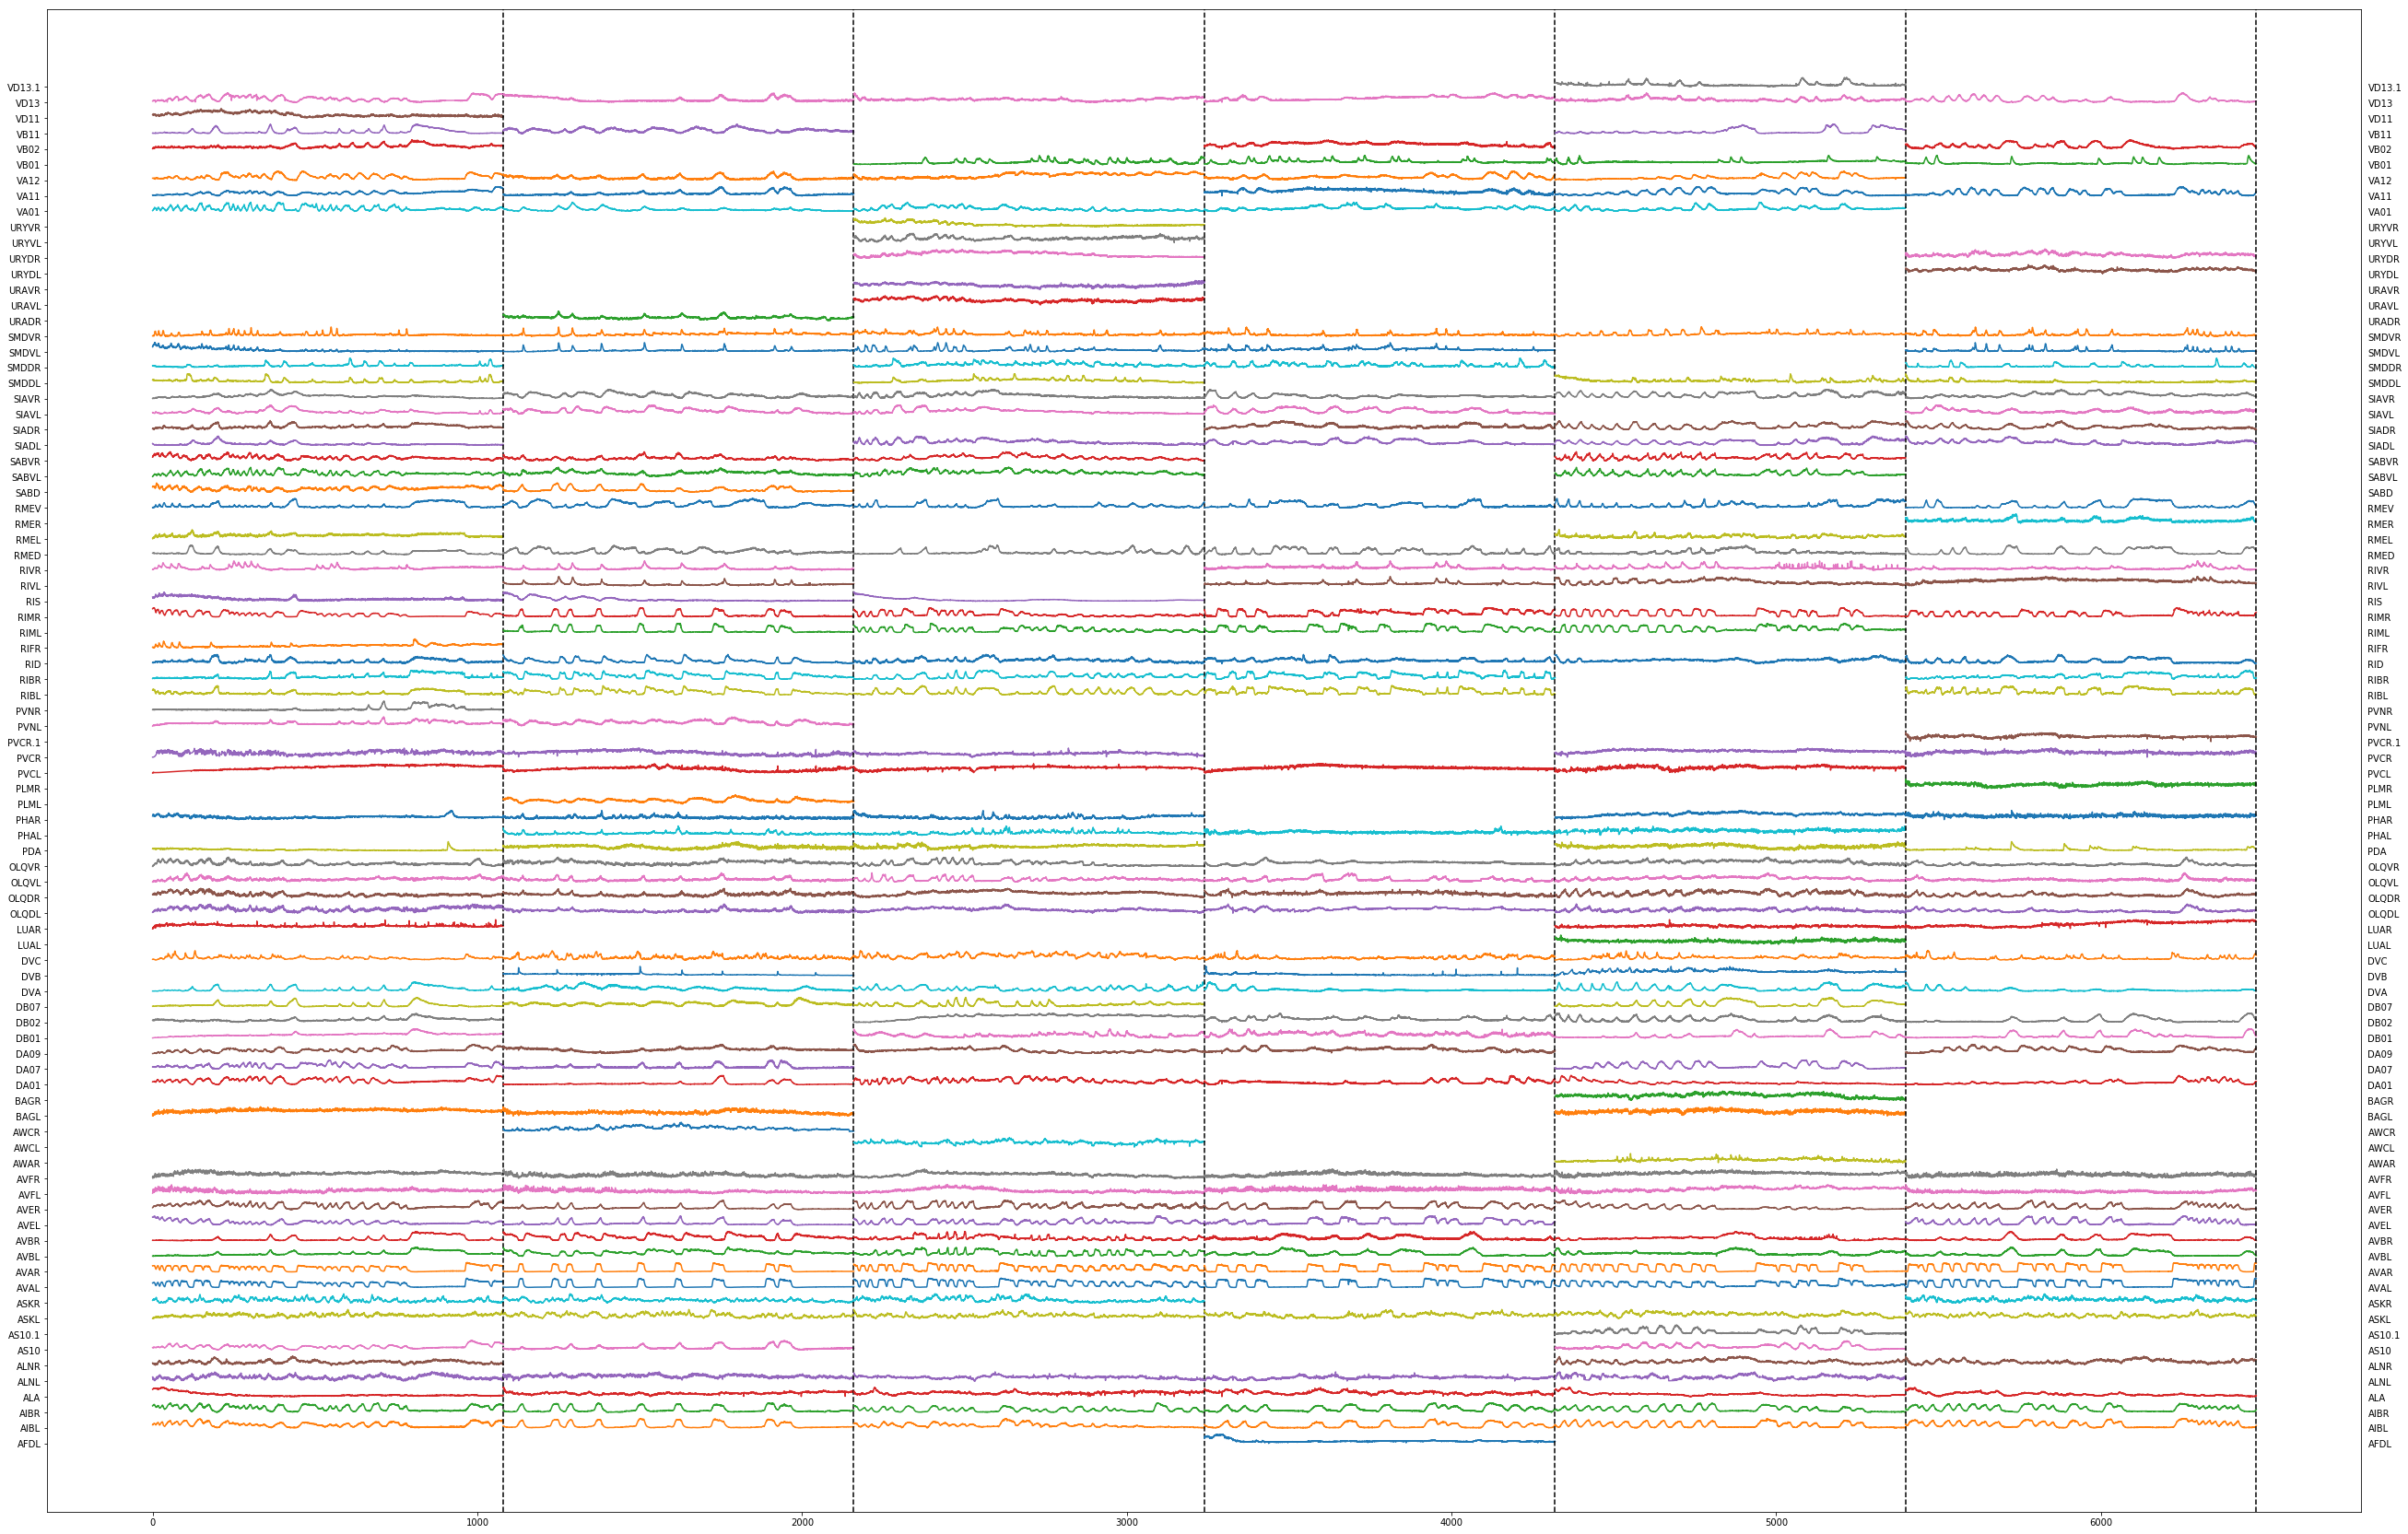

In [37]:
def comp_amp(func, neur=labelled, stretch=1.7, scaler=None, title=''):
    '''Plot traces given by @func accross datasets'''
    t = 0
    N = len(neur)
    cmap = plt.cm.get_cmap('tab10')
    plt.figure(figsize=(45,30))
    for i in range(N_sets):
        df = func(i)
        if scaler is not None:
            df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
        for j, n in enumerate(neur):
            try:
                plt.plot(t + df.index, df[n] + j*stretch, color=cmap(j%10))
            except:
                pass
        t += df.index[-1]
        plt.axvline(t, color='k', linestyle='--')
    
    plt.yticks(np.arange(0,N*stretch,stretch),labels=neur)   
    plt.tick_params(labeltop=False, labelright=True)
    plt.title(title, fontsize=20)
    plt.show()
            
comp_amp(traces)

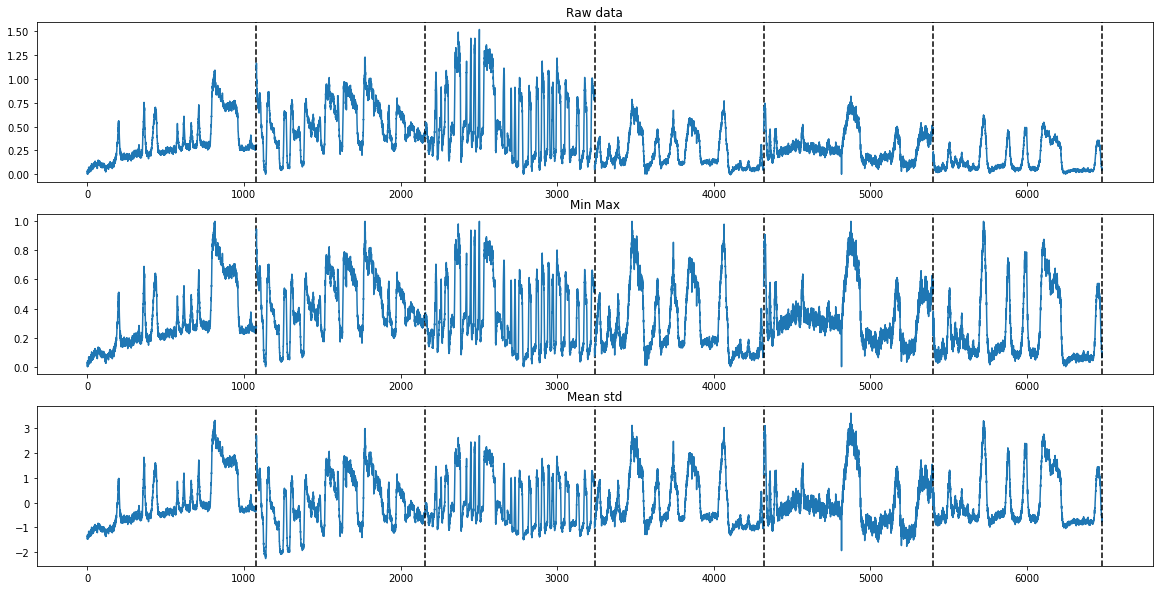

In [45]:
def compare_norm(neurons):
    """Compare the influence of different normalization methods on @neurons accross datasets"""
    def plot_avab(df=t0, scaler=None):
        t = 0
        stretch = 2
        cmap = plt.cm.get_cmap('tab10')
        for i in range(N_sets):
            df = traces(i)
            if scaler is not None:
                df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
            for j, n in enumerate(neurons):
                try:
                    plt.plot(t + df.index, df[n] + j*stretch, color=cmap(j%10))
                except:
                    pass
            t += df.index[-1]
            plt.axvline(t, color='k', linestyle='--')
        
    plt.figure(figsize=(20,10))
    plt.subplot(311)
    plt.title('Raw data')
    plot_avab()
    plt.subplot(312)
    plt.title('Min Max')
    plot_avab(scaler=minmax)
    plt.subplot(313)
    plt.title('Mean std')
    plot_avab(scaler=meanstd)
    plt.show()
    
compare_norm(['AVBL'])

# 3. Analysis

## 1. Correlation and distance

Correlation between AVAL and AVAR : 0.9842817407892739
Correlation between AVAL and DVA : -0.7546418442933499


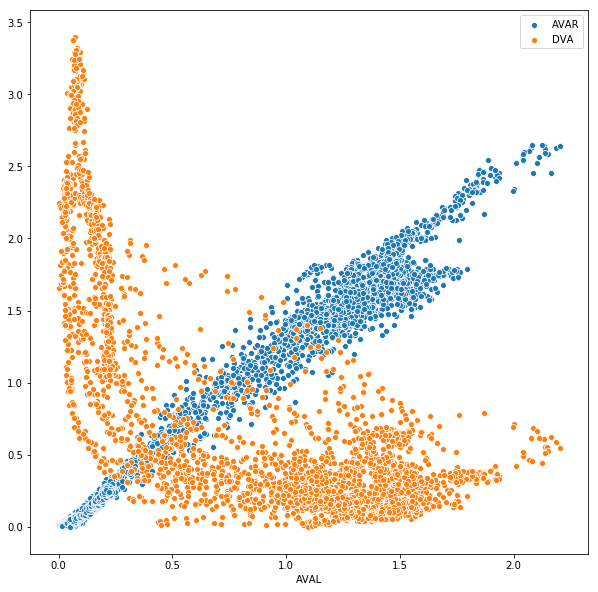

In [66]:
N0 = 'AVAL'
N1 = 'AVAR'
N2 = 'DVA'

plt.figure(figsize=(10,10))
sns.scatterplot(t0[N0], t0[N1], label=N1)
sns.scatterplot(t0[N0], t0[N2], label=N2)
print('Correlation between %s and %s : %s' % (N0,N1,np.corrcoef(t0[N0], t0[N1])[0,1]))
print('Correlation between %s and %s : %s' % (N0,N2,np.corrcoef(t0[N0], t0[N2])[0,1]))
plt.ylabel('')
plt.show()

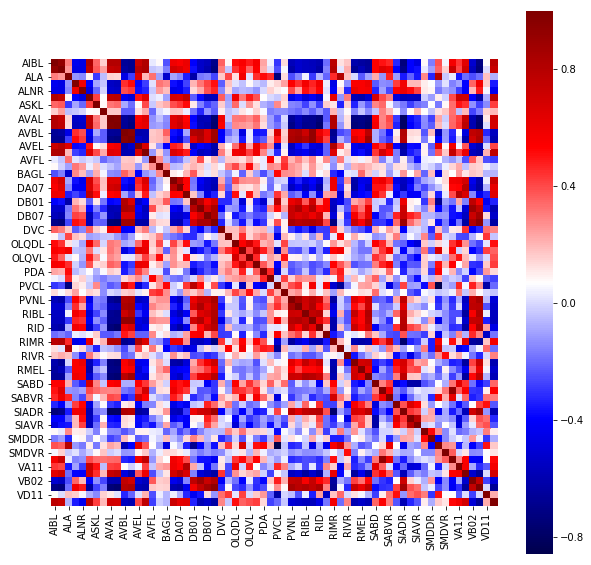

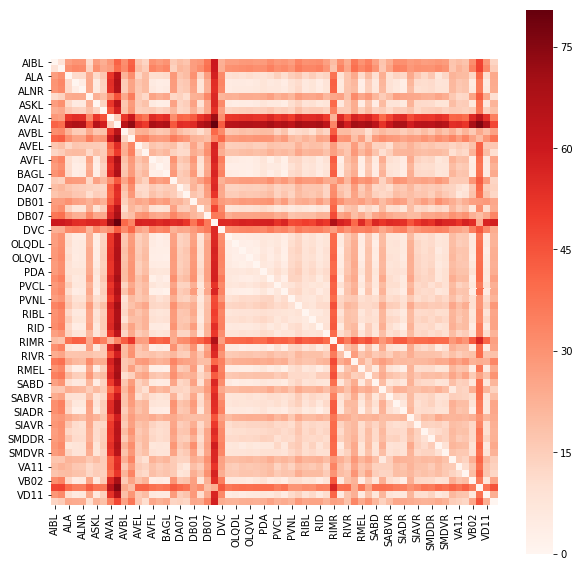

In [81]:
from scipy.spatial.distance import pdist, squareform

def get_labelled(df):
    return [n  for n in df.columns if any(c.isalpha() for c in n)]

def corr(df, vmin=None, vmax=None, cmap='flag'):
    corr = df.corr()
    heat(corr, vmin, vmax, cmap)

def dist_comp(df):
    distances = pdist(df.T.values, metric='euclidean')
    return squareform(distances)
def dist(df, vmin=None, vmax=None, cmap='flag'):
    dist = pd.DataFrame(dist_comp(df), columns = df.columns, index=df.columns)
    heat(dist, vmin, vmax, cmap)
    
def heat(df, vmin=None, vmax=None, cmap='flag'):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(df, cmap=cmap, square=True, ax=ax, vmax=vmax, vmin=vmin)
    
# dist(df[NAMES])
names = get_labelled(t0)
corr(t0[names], cmap='seismic')
plt.show()
dist(t0[names], cmap='Reds')
plt.show()

(3312, 154)


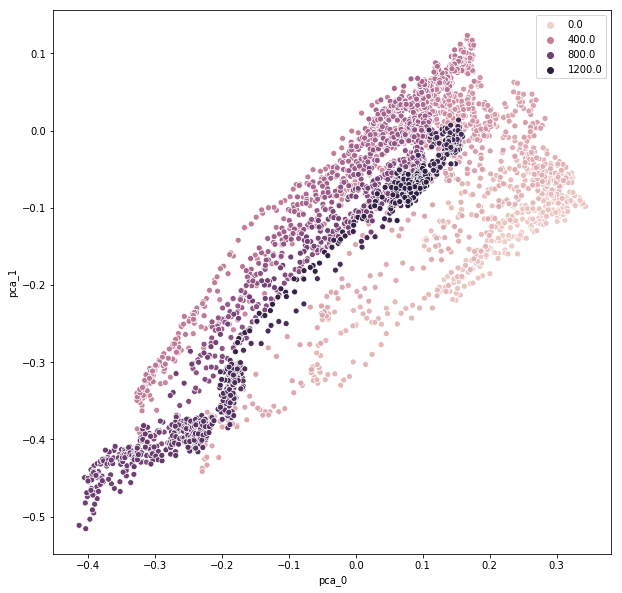

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [94]:
from sklearn.decomposition import PCA

def pca(df, pca=None, scaler=None, annotate=False):
    n = 2
    if scaler is not None:
        df2 = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
    else:
        df2 = df
    if pca is None:
        pca = PCA(n_components=n, whiten=True)
        pca.fit(df2)
    columns = ['pca_%i' % i for i in range(n)]
    df_pca = pd.DataFrame(pca.transform(df), columns=columns, index=df.index)
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.legend('')
    if annotate:
        for i, txt in enumerate(df.index):
                ax.annotate(txt, (df_pca.iloc[i, 0], df_pca.iloc[i, 1]))
#     sns.kdeplot(df_pca.iloc[:, 0], df_pca.iloc[:, 1], shade=True, shade_lowest=False, cmap='Reds')
    sns.scatterplot(x='pca_0', y='pca_1', data=df_pca, hue=df.index)
    plt.show()
    return pca
                    
# pca(df.T, annotate=True)
print(t0.shape)
pca(t0, scaler=meanstd)